In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Load the mock data
df = pd.read_csv('gene_expression.csv')

# Features (genes) and target
X = df.iloc[:, :-1]  # All columns except Label
y = pd.get_dummies(df['Label']).reindex(columns=['Cancer', 'Normal'], fill_value=0)['Cancer']  # Binary: 1=Cancer, 0=Normal

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset shape: {X.shape} (samples, genes)")
print(f"Class distribution: Normal {y.value_counts()[0]}, Cancer {y.value_counts()[1]}")

Dataset shape: (100, 20) (samples, genes)
Class distribution: Normal 50, Cancer 50


In [2]:
# Initialize the model and RFE (select top 5 features)
estimator = LogisticRegression(random_state=42, max_iter=1000)
rfe = RFE(estimator, n_features_to_select=5, step=1)  # Step=1 removes one feature per iteration

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
feature_ranking = rfe.ranking_  # Lower rank = more important (1 = selected)

print("Selected genes:", list(selected_features))
print("Feature rankings:", dict(zip(X_train.columns, feature_ranking)))


Selected genes: ['Gene_1', 'Gene_2', 'Gene_3', 'Gene_5', 'Gene_7']
Feature rankings: {'Gene_1': 1, 'Gene_2': 1, 'Gene_3': 1, 'Gene_4': 4, 'Gene_5': 1, 'Gene_6': 2, 'Gene_7': 1, 'Gene_8': 15, 'Gene_9': 3, 'Gene_10': 6, 'Gene_11': 8, 'Gene_12': 10, 'Gene_13': 14, 'Gene_14': 16, 'Gene_15': 7, 'Gene_16': 12, 'Gene_17': 5, 'Gene_18': 13, 'Gene_19': 9, 'Gene_20': 11}


In [3]:
# Transform train/test to selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train final model
final_model = LogisticRegression(random_state=42, max_iter=1000)
final_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy on test set: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy on test set: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



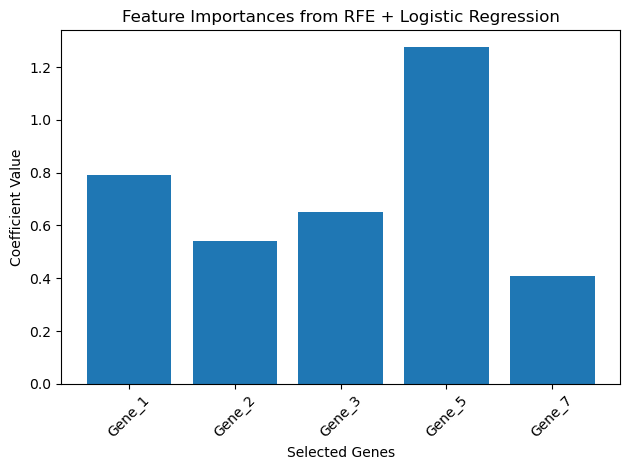

In [4]:
import matplotlib.pyplot as plt

# Coefficients as importances
importances = final_model.coef_[0]
plt.bar(range(len(selected_features)), importances)
plt.xticks(range(len(selected_features)), selected_features, rotation=45)
plt.xlabel('Selected Genes')
plt.ylabel('Coefficient Value')
plt.title('Feature Importances from RFE + Logistic Regression')
plt.tight_layout()
plt.show()
